# PATTERN RECOGNITION COURSEWORK 2
## REPRESENTATION AND DISTANCE METRIC LEARNING

In [1]:
# Imports
from scipy.io import loadmat
import json
import numpy as np
import random
from metric_learn.lmnn import LMNN
from metric_learn.covariance import Covariance
from metric_learn.mlkr import MLKR
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set a random see so that results are replicable
random.seed(9999999)

### Data Preparation

In [2]:
# Access raw data from files
train_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()-1
query_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()-1
gallery_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()-1
labels = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
camId = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()
filelist = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
with open('PR_data/feature_data.json','r') as f:
    features = json.load(f)
features = np.array(features) # rows: pictures, columns: features (one row contains one image)

In [3]:
# Create the usable data sets from the given indices
train_feat = features[train_idxs,:]
train_labels = labels[train_idxs]
train_camId = camId[train_idxs]
query_feat = features[query_idxs,:]
query_labels = labels[query_idxs]
query_camId = camId[query_idxs]
gallery_feat = features[gallery_idxs,:]
gallery_labels = labels[gallery_idxs]
gallery_camId = camId[gallery_idxs]

In [4]:
# Create a validation set
unique_id_train = np.unique(train_labels) #find all unique training IDs
unique_id_val = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),100))] # pick 100 random unique training IDs
bool_idx_val = np.isin(train_labels, unique_id_val)
bool_idx_train_noval = np.isin(train_labels, unique_id_val, invert=True)

train_noval_feat = train_feat[bool_idx_train_noval,:]
train_noval_labels = train_labels[bool_idx_train_noval]
train_noval_camId = train_camId[bool_idx_train_noval]
train_noval_filelist_idxs = train_idxs[bool_idx_train_noval]

val_feat = train_feat[bool_idx_val,:]
val_labels = train_labels[bool_idx_val]
val_camId = train_camId[bool_idx_val]
val_filelist_idxs = train_idxs[bool_idx_val]

<b> Validation Query and Gallery set: </b> <br>
Make sure that the query and gallery for validation are similarly structured as the gallery and query set for testing (i.e. take one picture from each camera and person for the query set - only valid if that sample has at least one complementary image from the other camera in the gallery set)

In [5]:
# Create gallery and query set for validation
val_label_cam_pair = np.append(val_labels.reshape((1,val_labels.shape[0])),val_camId.reshape((1,val_camId.shape[0])),axis=0)
val_pair_unique, val_pair_unique_indxs = np.unique(val_label_cam_pair, axis=1, return_index=True)

val_query_feat = val_feat[val_pair_unique_indxs,:]
val_query_labels = val_labels[val_pair_unique_indxs]
val_query_camId = val_camId[val_pair_unique_indxs]

val_gallery_feat = np.delete(val_feat, val_pair_unique_indxs, axis = 0)
val_gallery_labels = np.delete(val_labels, val_pair_unique_indxs)
val_gallery_camId = np.delete(val_camId, val_pair_unique_indxs)

idxs_delete = []
for i in range(val_query_labels.shape[0]):
    g_camId = val_gallery_camId[val_gallery_labels==val_query_labels[i]]
    if (val_query_camId[i]==1 and (2 not in g_camId)) or (val_query_camId[i]==2 and (1 not in g_camId)):
        val_gallery_feat = np.append(val_gallery_feat, val_query_feat[[i],:],axis=0)
        val_gallery_labels = np.append(val_gallery_labels, val_query_labels[i])
        val_gallery_camId = np.append(val_gallery_camId, val_query_camId[i])
        idxs_delete.append(i)

val_query_feat = np.delete(val_query_feat, idxs_delete, axis = 0)
val_query_labels = np.delete(val_query_labels, idxs_delete)
val_query_camId = np.delete(val_query_camId, idxs_delete)

### Create Evaluation functions

<b> Evaluation function for testing </b>

In [6]:
def kNN (t_query_feat, t_gallery_feat):
    # k nearest neighbours implementation
    k = 10
    top_k_rank = np.zeros((query_labels.shape[0],k))
    top_k_precision = np.zeros((query_labels.shape[0],k))
    top_k_recall = np.zeros((query_labels.shape[0],k))

    nbrs = NearestNeighbors(n_neighbors=20).fit(t_gallery_feat)
    distances, indices = nbrs.kneighbors(t_query_feat)
    # Indices contains indices of the closes gallery pictures to each query image

    # Select the images where camId and label not the same as of the query image
    # Take top k of them

    for i in range (0, query_labels.shape[0], 1):
        selected_indices = np.logical_not(np.logical_and(gallery_camId[indices[i, :]] == query_camId[i], gallery_labels[indices[i,:]] == query_labels[i]))
        number_of_removed = np.sum(np.logical_and(gallery_camId == query_camId[i], gallery_labels == query_labels[i]))
        removed_indices = indices [i, selected_indices]
        is_same_label = (query_labels[i] == gallery_labels[removed_indices])

        for j in range (0, k, 1):
            top_k_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
            top_k_precision[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
            top_k_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(gallery_labels==query_labels[i])-number_of_removed)
    
    # calculate mAP
    average_precisions = np.zeros((query_labels.shape))
    for j in range (0, query_labels.shape[0], 1):
        recall = top_k_recall[j, :]
        precision = top_k_precision[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    # print results
    print("Mean average precision:", average_precisions.mean())
    print("Top1:", top_k_rank[:, 0].mean())
    print("Top5:", top_k_rank[:, 4].mean())
    print("Top10:", top_k_rank[:, 9].mean())
    print("Top5-Precision:", top_k_precision[:, 4].mean())
    print("Top5-Recall:", top_k_recall[:, 4].mean())
    return

<b> Evaluation function for validation </b>

In [7]:
def kNN_val (t_query_feat, t_gallery_feat):
    # k nearest neighbours implementation
    k = 10
    top_k_rank = np.zeros((val_query_labels.shape[0],k))
    top_k_precision = np.zeros((val_query_labels.shape[0],k))
    top_k_recall = np.zeros((val_query_labels.shape[0],k))

    nbrs = NearestNeighbors(n_neighbors=20).fit(t_gallery_feat)
    distances, indices = nbrs.kneighbors(t_query_feat)
    # Indices contains indices of the closes gallery pictures to each query image

    # Select the images where camId and label not the same as of the query image
    # Take top k of them

    for i in range (0, val_query_labels.shape[0], 1):
        selected_indices = np.logical_not(np.logical_and(val_gallery_camId[indices[i, :]] == val_query_camId[i], val_gallery_labels[indices[i,:]] == val_query_labels[i]))
        number_of_removed = np.sum(np.logical_and(val_gallery_camId == val_query_camId[i], val_gallery_labels == val_query_labels[i]))
        removed_indices = indices [i, selected_indices]
        is_same_label = (val_query_labels[i] == val_gallery_labels[removed_indices])

        for j in range (0, k, 1):
            top_k_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
            top_k_precision[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
            top_k_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(val_gallery_labels==val_query_labels[i])-number_of_removed)

    # calculate mAP
    average_precisions = np.zeros((val_query_labels.shape))
    for j in range (0, val_query_labels.shape[0], 1):
        recall = top_k_recall[j, :]
        precision = top_k_precision[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    # print results
    print("Mean average precision:", average_precisions.mean())
    print("Top1:", top_k_rank[:, 0].mean())
    print("Top5:", top_k_rank[:, 4].mean())
    print("Top10:", top_k_rank[:, 9].mean())
    print("Top5-Precision:", top_k_precision[:, 4].mean())
    print("Top5-Recall:", top_k_recall[:, 4].mean())
    return

### TODO KMEANS AND CMC -> INCLUDE THEM IN THE EVALUATION FUNCTION

In [ ]:
# Kmeans clustering

# very long 
#k_means_predictions = np.zeros((query_labels.shape[0]))
#for i in range (0, query_labels.shape[0], 1):
#    gallery_feat_removed, gallery_labels_removed = get_removed_gallery (i)
#    kmeans = KMeans(n_clusters=((np.unique(gallery_labels_removed)).shape[0]), n_init=1, max_iter=10, random_state=0, precompute_distances= True).fit(gallery_feat_removed)
#    k_means_predictions[i] = kmeans.predict(query_feat[i:(i+1), :])
#    print (i)
#    print (k_means_predictions[i], query_labels[i])
#accuracy = (np.sum(k_means_predictions == query_labels))/(query_labels.shape[0])
#print (accuracy)
#print(k_means_predictions, k_means_predictions.shape, query_labels, query_labels.shape)

import sklearn.utils.linear_assignment_ as la
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score

def best_map(l1, l2):
    """
    Permute labels of l2 to match l1 as much as possible
    """
    if len(l1) != len(l2):
        print("L1.shape must == L2.shape")
        exit(0)

    label1 = np.unique(l1)
    n_class1 = len(label1)

    label2 = np.unique(l2)
    n_class2 = len(label2)

    n_class = max(n_class1, n_class2)
    G = np.zeros((n_class, n_class))

    for i in range(0, n_class1):
        for j in range(0, n_class2):
            ss = l1 == label1[i]
            tt = l2 == label2[j]
            G[i, j] = np.count_nonzero(ss & tt)

    A = la.linear_assignment(-G)

    new_l2 = np.zeros(l2.shape)
    for i in range(0, n_class2):
        new_l2[l2 == label2[A[i][1]]] = label1[A[i][0]]
    return new_l2.astype(int)

k_means_predictions = np.zeros((query_labels.shape[0]))

kmeans = KMeans (n_clusters=np.unique(gallery_labels).shape[0], n_init =1, max_iter = 10, random_state = 0, precompute_distances=True).fit(gallery_feat)

labels = best_map(gallery_labels, kmeans.labels_)

#for i in range (0, query_labels.shape[0], 1):
#    k_means_predictions[i] = kmeans.predict(query_feat[i:(i+1), :])
#    print (i)
#    print (k_means_predictions[i], query_labels[i])
#accuracy = (np.sum(k_means_predictions == labels))/(query_labels.shape[0])
#print (accuracy)
#print(k_means_predictions, k_means_predictions.shape, query_labels, query_labels.shape)

In [ ]:
print (labels, gallery_labels, kmeans.labels_)
print (labels.shape, gallery_labels.shape, kmeans.labels_.shape)

[1426   51   51 ... 1463 1463 1463] [   3    3    3 ... 1463 1463 1463] [582  63  63 ... 178 178 178]
(5328,) (5328,) (5328,)


In [ ]:
np.sum(labels==gallery_labels)

3604

### BASELINE APPROACH

<b> Evaluation of original features </b>

In [8]:
kNN(query_feat, gallery_feat)

Mean average precision: 0.4353663677592249
Top1: 0.47
Top5: 0.6685714285714286
Top10: 0.7492857142857143
Top5-Precision: 0.3425714285714286
Top5-Recall: 0.4498214285714286


<b> Evaluation of validation set with original features </b>

In [9]:
kNN_val(val_query_feat, val_gallery_feat)

Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


### Feature Reduction

<b> PCA </b> <br>
Plot the eigenvalues of the training set:

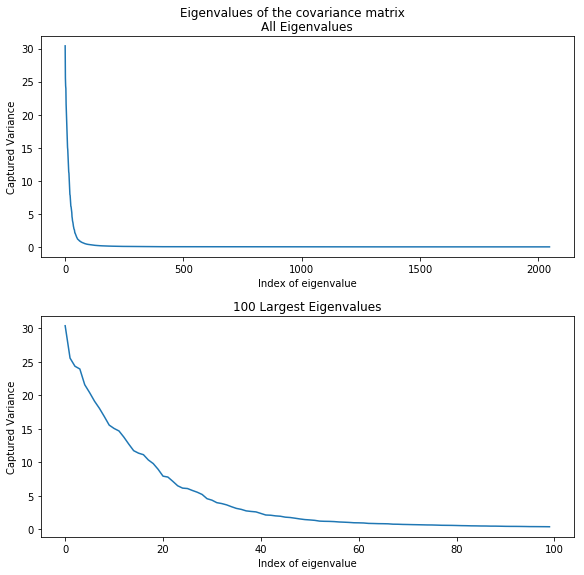

Percentage of total data variance captured by 500 largest eigenvectors: 0.9292050565369442
Percentage of total data variance captured by 500 largest eigenvectors: 0.9733843233063826
Percentage of total data variance captured by 500 largest eigenvectors: 0.9896934896951645


In [10]:
pca_train =PCA()
pca_train.fit(train_feat)
pca_train_eigvals = pca_train.explained_variance_

x = np.arange(0, pca_train_eigvals.shape[0])
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, pca_train_eigvals, '-')
axs[0].set_title('All Eigenvalues')
axs[0].set_xlabel("Index of eigenvalue")
axs[0].set_ylabel("Captured Variance")

fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:100], pca_train_eigvals[:100], '-')
axs[1].set_title('100 Largest Eigenvalues')
axs[1].set_xlabel("Index of eigenvalue")
axs[1].set_ylabel("Captured Variance")
plt.show()

print("Percentage of total data variance captured by 500 largest eigenvectors:", 
      (np.sum(pca_train_eigvals[:100]))/(np.sum(pca_train_eigvals[:100])+np.sum(pca_train_eigvals[100:])))
print("Percentage of total data variance captured by 500 largest eigenvectors:", 
      (np.sum(pca_train_eigvals[:250]))/(np.sum(pca_train_eigvals[:250])+np.sum(pca_train_eigvals[250:])))
print("Percentage of total data variance captured by 500 largest eigenvectors:", 
      (np.sum(pca_train_eigvals[:500]))/(np.sum(pca_train_eigvals[:500])+np.sum(pca_train_eigvals[500:])))

Validate for reduced dimensions:

In [11]:
for i in [100, 250, 500]:
    pca_train_noval =PCA(n_components = i)
    pca_train_noval.fit(train_noval_feat)
    print("\nPCA with {} dimensions:".format(i))
    kNN_val(pca_train_noval.transform(val_query_feat), pca_train_noval.transform(val_gallery_feat))


PCA with 100 dimensions:
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

PCA with 250 dimensions:
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

PCA with 500 dimensions:
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


Evaluate PCA feature transform on test set:

In [12]:
for i in [100, 250, 500]:
    pca_train = PCA(n_components=i)
    pca_train.fit(train_feat)
    print("\nPCA with {} dimensions:".format(i))
    kNN(pca_train.transform(query_feat), pca_train.transform(gallery_feat))


PCA with 100 dimensions:
Mean average precision: 0.43453251906823337
Top1: 0.4685714285714286
Top5: 0.6764285714285714
Top10: 0.7485714285714286
Top5-Precision: 0.34271428571428575
Top5-Recall: 0.45023809523809516

PCA with 250 dimensions:
Mean average precision: 0.43549765512265515
Top1: 0.4685714285714286
Top5: 0.6728571428571428
Top10: 0.75
Top5-Precision: 0.3431428571428572
Top5-Recall: 0.4513690476190476

PCA with 500 dimensions:
Mean average precision: 0.4356578025149454
Top1: 0.4692857142857143
Top5: 0.6714285714285714
Top10: 0.7492857142857143
Top5-Precision: 0.34271428571428575
Top5-Recall: 0.45077380952380947


FINAL PCA TRANSFORMATIONS - USED IN THE CODE LATER:

In [13]:
pca = PCA(n_components = 500)
train_feat_PCA_500 = pca.fit_transform(train_feat)
query_feat_PCA_500 = pca.transform(query_feat)
gallery_feat_PCA_500 = pca.transform(gallery_feat)
train_noval_feat_PCA_500 = pca.fit_transform(train_noval_feat)
val_query_feat_PCA_500 = pca.transform(val_query_feat)
val_gallery_feat_PCA_500 = pca.transform(val_gallery_feat)

pca = PCA(n_components = 50)
train_feat_PCA_50 = pca.fit_transform(train_feat)
query_feat_PCA_50 = pca.transform(query_feat)
gallery_feat_PCA_50 = pca.transform(gallery_feat)
train_noval_feat_PCA_50 = pca.fit_transform(train_noval_feat)
val_query_feat_PCA_50 = pca.transform(val_query_feat)
val_gallery_feat_PCA_50 = pca.transform(val_gallery_feat)

<b> LDA

Validate for reduced dimensions:

In [14]:
for i in [50, 100, 250, 500]:
    lda_train_noval =LinearDiscriminantAnalysis(n_components = i)
    lda_train_noval.fit(train_noval_feat, train_noval_labels)
    print("\nLDA with {} dimensions:".format(i))
    kNN_val(lda_train_noval.transform(val_query_feat), lda_train_noval.transform(val_gallery_feat))


LDA with 50 dimensions:
Mean average precision: 0.9839674563292653
Top1: 0.9949748743718593
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7437185929648241
Top5-Recall: 0.9861809045226131

LDA with 100 dimensions:
Mean average precision: 0.9970077661032434
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7517587939698491
Top5-Recall: 0.9962311557788944

LDA with 250 dimensions:
Mean average precision: 0.9985076899649763
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7527638190954772
Top5-Recall: 0.9974874371859297

LDA with 500 dimensions:
Mean average precision: 0.99945180447693
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


Evaluate LDA feature transform on test set:

In [15]:
for i in [50, 100, 250, 500]:
    lda_train = LinearDiscriminantAnalysis(n_components=i)
    lda_train.fit(train_feat, train_labels)
    print("\nLDA with {} dimensions:".format(i))
    kNN(lda_train.transform(query_feat), lda_train.transform(gallery_feat))


LDA with 50 dimensions:
Mean average precision: 0.3436014996907854
Top1: 0.39285714285714285
Top5: 0.5771428571428572
Top10: 0.665
Top5-Precision: 0.274
Top5-Recall: 0.35892857142857143

LDA with 100 dimensions:
Mean average precision: 0.36187585034013603
Top1: 0.41785714285714287
Top5: 0.6007142857142858
Top10: 0.6935714285714286
Top5-Precision: 0.28585714285714287
Top5-Recall: 0.37464285714285717

LDA with 250 dimensions:
Mean average precision: 0.3757265254586683
Top1: 0.42428571428571427
Top5: 0.6221428571428571
Top10: 0.7128571428571429
Top5-Precision: 0.2962857142857143
Top5-Recall: 0.3884523809523809

LDA with 500 dimensions:
Mean average precision: 0.3745382395382395
Top1: 0.41714285714285715
Top5: 0.6221428571428571
Top10: 0.7142857142857143
Top5-Precision: 0.2988571428571428
Top5-Recall: 0.39220238095238097


FINAL LDA TRANSFORMATION:

In [16]:
lda = LinearDiscriminantAnalysis(n_components = 500)
train_feat_LDA = lda.fit_transform(train_feat, train_labels)
query_feat_LDA = lda.transform(query_feat)
gallery_feat_LDA = lda.transform(gallery_feat)
train_noval_feat_LDA = lda.fit_transform(train_noval_feat, train_noval_labels)
val_query_feat_LDA = lda.transform(val_query_feat)
val_gallery_feat_LDA = lda.transform(val_gallery_feat)

### MAHALANOBIS DISTANCE LEARNING

<b> Original covariance based approach </b>

Validation on all dimension:

In [17]:
Cov_Model_val = Covariance().fit(train_noval_feat, train_noval_labels)
val_query_feat_Cov = Cov_Model_val.transform(val_query_feat)
val_gallery_feat_Cov = Cov_Model_val.transform(val_gallery_feat)
kNN_val(val_query_feat_Cov, val_gallery_feat_Cov)

Mean average precision: 0.979396984924623
Top1: 0.9949748743718593
Top5: 0.9949748743718593
Top10: 1.0
Top5-Precision: 0.7386934673366833
Top5-Recall: 0.9761306532663316


Validation on reduced dimensions:

In [18]:
for i in [50, 100, 250, 500]:
    print("\nPCA-COV with {} dimensions:".format(i))
    pca_train_noval = PCA(n_components=i)
    train_noval_feat_PCA_t = pca_train_noval.fit_transform(train_noval_feat)
    val_query_feat_PCA_t = pca_train_noval.transform(val_query_feat) 
    val_gallery_feat_PCA_t = pca_train_noval.transform(val_gallery_feat)
    Cov_Model_val = Covariance().fit(train_noval_feat_PCA_t, train_noval_labels)
    val_query_feat_Cov_PCA = Cov_Model_val.transform(val_query_feat_PCA_t)
    val_gallery_feat_Cov_PCA = Cov_Model_val.transform(val_gallery_feat_PCA_t)
    kNN_val(val_query_feat_Cov_PCA, val_gallery_feat_Cov_PCA)
    
    print("\nLDA-COV with {} dimensions:".format(i))
    lda_train_noval = LinearDiscriminantAnalysis(n_components=i)
    train_noval_feat_LDA_t = lda_train_noval.fit_transform(train_noval_feat, train_noval_labels)
    val_query_feat_LDA_t = lda_train_noval.transform(val_query_feat) 
    val_gallery_feat_LDA_t = lda_train_noval.transform(val_gallery_feat)
    Cov_Model_val = Covariance().fit(train_noval_feat_LDA_t, train_noval_labels)
    val_query_feat_Cov_LDA = Cov_Model_val.transform(val_query_feat_LDA_t)
    val_gallery_feat_Cov_LDA = Cov_Model_val.transform(val_gallery_feat_LDA_t)
    kNN_val(val_query_feat_Cov_LDA, val_gallery_feat_Cov_LDA)


PCA-COV with 50 dimensions:
Mean average precision: 0.9992690726359068
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

LDA-COV with 50 dimensions:
Mean average precision: 0.9747123061193412
Top1: 0.9849246231155779
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7396984924623115
Top5-Recall: 0.9811557788944724

PCA-COV with 100 dimensions:
Mean average precision: 0.999725902238465
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

LDA-COV with 100 dimensions:
Mean average precision: 0.9948073701842546
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7497487437185929
Top5-Recall: 0.9937185929648241

PCA-COV with 250 dimensions:
Mean average precision: 0.9995431703974418
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7537688442211053
Top5-Recall: 0.9987437185929648

LDA-COV with 250 dimensions:
Mean average precision: 0.9946811981987861
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7497487437185929
Top5-Recall: 0.993718592

Test on all dimension:

In [19]:
Cov_Model = Covariance().fit(train_feat, train_labels)
query_feat_Cov = Cov_Model.transform(query_feat)
gallery_feat_Cov = Cov_Model.transform(gallery_feat)
kNN(query_feat_Cov, gallery_feat_Cov)

Mean average precision: 0.2337029220779221
Top1: 0.3092857142857143
Top5: 0.455
Top10: 0.5014285714285714
Top5-Precision: 0.18885714285714283
Top5-Recall: 0.2478571428571428


Test on reduced dimensions (PCA-50-dimensions):

In [20]:
Cov_Model = Covariance().fit(train_feat_PCA_50, train_labels)
query_feat_Cov_PCA = Cov_Model.transform(query_feat_PCA_50)
gallery_feat_Cov_PCA = Cov_Model.transform(gallery_feat_PCA_50)
kNN(query_feat_Cov_PCA, gallery_feat_Cov_PCA)

Mean average precision: 0.390218537414966
Top1: 0.4307142857142857
Top5: 0.6371428571428571
Top10: 0.7107142857142857
Top5-Precision: 0.307
Top5-Recall: 0.4027380952380952


<b> Large Margin Nearest Neighbours 

Validation on all dimension:

In [ ]:
LargeMarg_Model = LMNN(verbose=True).fit(train_noval_feat,train_noval_labels)
val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat)
val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat)
kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)

Validation on reduced dimensions - PCA:

In [22]:
LargeMarg_Model = LMNN(verbose=True).fit(train_noval_feat_PCA_50,train_noval_labels)
val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat_PCA_50)
val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat_PCA_50)
print("PCA-LMNN with 50 dimensions:")
kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)

LargeMarg_Model = LMNN(verbose=True).fit(train_noval_feat_PCA_500,train_noval_labels)
val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat_PCA_500)
val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat_PCA_500)
print("PCA-LMNN with 500 dimensions:")
kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)

/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 426205.3505330503 -1986.03270395234 46 1.0099999999999999e-07
3 424209.49658753513 -1995.8539455151767 46 1.0201e-07
4 422199.46581847203 -2010.0307690631016 46 1.030301e-07
5 420175.5792956003 -2023.8865228717332 45 1.0406040099999999e-07
6 418139.40073424025 -2036.1785613600514 44 1.0510100500999999e-07
7 416089.97406359215 -2049.4266706480994 44 1.0615201506009999e-07
8 414026.41549335717 -2063.558570234978 43 1.0721353521070098e-07
9 411950.9807652671 -2075.4347280900693 41 1.08285670562808e-07
10 409864.33312955755 -2086.6476357095526 39 1.0936852726843608e-07
11 407764.9992526966 -2099.3338768609683 38 1.1046221254112044e-07
12 405652.3872425703 -2112.612010126293 35 1.1156683466653164e-07
13 403528.99305547157 -2123.3941870987182 35 1.1268250301319696e-07
14 401391.2683750809 -2137.7246803906746 34 1.1380932804332893e-07
15 399240.5115192417 -2150.756855839165 34 1.1494742132376222e-07
16 397075.40797966864 -2165.103539573087 34 1.1609689553699984e-07
17 394895.9582233088 -217

135 90198.60911155588 -1811.6021748531057 2 3.7937096290198303e-07
136 88443.97204378064 -1754.637067775242 2 3.8316467253100284e-07
137 86748.37886484349 -1695.5931789371534 2 3.8699631925631286e-07
138 85113.95947784901 -1634.419386994472 2 3.9086628244887597e-07
139 83542.89602816373 -1571.0634496852872 2 3.947749452733647e-07
140 82037.42404779734 -1505.4719803663902 2 3.987226947260984e-07
141 80599.83362372982 -1437.5904240675154 2 4.027099216733594e-07
142 79232.49359843646 -1367.3400252933643 3 4.0673702089009297e-07
143 77938.56685966208 -1293.9267387743748 3 4.108043910989939e-07
144 76719.99847532173 -1218.568384340353 4 4.1491243500998386e-07
145 75579.84634823883 -1140.1521270828962 5 4.190615593600837e-07
146 74520.51056654497 -1059.335781693866 5 4.2325217495368454e-07
147 73544.3004879401 -976.2100786048686 6 4.2748469670322137e-07
148 72654.3935438616 -889.9069440784951 6 4.317595436702536e-07
149 71853.57515282535 -800.8183910362568 8 4.3607713910695614e-07
150 71145.

/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 609178.3512521915 -2129.4583602615166 28 1.0099999999999999e-07
3 607033.6349467647 -2144.7163054267876 27 1.0201e-07
4 604874.8866688842 -2158.7482778804842 27 1.030301e-07
5 602700.7334705363 -2174.1531983478926 26 1.0406040099999999e-07
6 600512.5939050626 -2188.1395654736552 25 1.0510100500999999e-07
7 598310.720187952 -2201.873717110604 24 1.0615201506009999e-07
8 596094.3087417948 -2216.411446157261 24 1.0721353521070098e-07
9 593862.8092494755 -2231.4994923193008 23 1.08285670562808e-07
10 591617.6485438145 -2245.1607056609355 22 1.0936852726843608e-07
11 589357.8952005858 -2259.7533432287164 21 1.1046221254112044e-07
12 587083.5265098652 -2274.368690720643 20 1.1156683466653164e-07
13 584794.8360663985 -2288.6904434666503 19 1.1268250301319696e-07
14 582491.7756012398 -2303.0604651587782 19 1.1380932804332893e-07
15 580173.0752279967 -2318.700373243075 19 1.1494742132376222e-07
16 577838.7271005886 -2334.3481274080696 19 1.1609689553699984e-07
17 575488.7262803889 -2350.00082

127 260774.67924708658 -2433.308323363366 0 3.50342719336941e-07
128 258385.87602702188 -2388.8032200646994 0 3.538461465303104e-07
129 256043.4066088386 -2342.4694181832892 0 3.573846079956135e-07
130 253749.14578942006 -2294.2608194185304 0 3.6095845407556966e-07
131 251505.01548394258 -2244.130305477476 0 3.645680386163254e-07
132 249312.98576730047 -2192.029716642108 0 3.6821371900248867e-07
133 247175.07593740843 -2137.9098298920435 0 3.7189585619251353e-07
134 245093.3556008316 -2081.7203365768364 0 3.7561481475443865e-07
135 243069.945781194 -2023.4098196375999 0 3.7937096290198303e-07
136 241107.020050843 -1962.9257303509803 0 3.8316467253100284e-07
137 239206.80568624026 -1900.2143646027544 0 3.8699631925631286e-07
138 237371.58484756664 -1835.2208386736165 0 3.9086628244887597e-07
139 235603.69578303955 -1767.8890645270876 0 3.947749452733647e-07
140 233905.53405844973 -1698.1617245898233 0 3.987226947260984e-07
141 232279.553812431 -1625.9802460187348 0 4.027099216733594e-07

Validation on number of k:

In [32]:
for k in [3,5]:
    LargeMarg_Model = LMNN(verbose=True, k=k).fit(train_noval_feat_PCA_50,train_noval_labels)
    val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat_PCA_50)
    val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat_PCA_50)
    print("PCA-LMNN with 50 dimensions and k={}:".format(k))
    kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)


/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 426205.3505330503 -1986.03270395234 46 1.0099999999999999e-07
3 424209.49658753513 -1995.8539455151767 46 1.0201e-07
4 422199.46581847203 -2010.0307690631016 46 1.030301e-07
5 420175.5792956003 -2023.8865228717332 45 1.0406040099999999e-07
6 418139.40073424025 -2036.1785613600514 44 1.0510100500999999e-07
7 416089.97406359215 -2049.4266706480994 44 1.0615201506009999e-07
8 414026.41549335717 -2063.558570234978 43 1.0721353521070098e-07
9 411950.9807652671 -2075.4347280900693 41 1.08285670562808e-07
10 409864.33312955755 -2086.6476357095526 39 1.0936852726843608e-07
11 407764.9992526966 -2099.3338768609683 38 1.1046221254112044e-07
12 405652.3872425703 -2112.612010126293 35 1.1156683466653164e-07
13 403528.99305547157 -2123.3941870987182 35 1.1268250301319696e-07
14 401391.2683750809 -2137.7246803906746 34 1.1380932804332893e-07
15 399240.5115192417 -2150.756855839165 34 1.1494742132376222e-07
16 397075.40797966864 -2165.103539573087 34 1.1609689553699984e-07
17 394895.9582233088 -217

134 92010.21128640899 -1866.538523590716 2 3.7561481475443865e-07
135 90198.60911155588 -1811.6021748531057 2 3.7937096290198303e-07
136 88443.97204378064 -1754.637067775242 2 3.8316467253100284e-07
137 86748.37886484349 -1695.5931789371534 2 3.8699631925631286e-07
138 85113.95947784901 -1634.419386994472 2 3.9086628244887597e-07
139 83542.89602816373 -1571.0634496852872 2 3.947749452733647e-07
140 82037.42404779734 -1505.4719803663902 2 3.987226947260984e-07
141 80599.83362372982 -1437.5904240675154 2 4.027099216733594e-07
142 79232.49359843646 -1367.3400252933643 3 4.0673702089009297e-07
143 77938.56685966208 -1293.9267387743748 3 4.108043910989939e-07
144 76719.99847532173 -1218.568384340353 4 4.1491243500998386e-07
145 75579.84634823883 -1140.1521270828962 5 4.190615593600837e-07
146 74520.51056654497 -1059.335781693866 5 4.2325217495368454e-07
147 73544.3004879401 -976.2100786048686 6 4.2748469670322137e-07
148 72654.3935438616 -889.9069440784951 6 4.317595436702536e-07
149 71853.

/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 910478.4096892874 -10163.797583322506 287 1.0099999999999999e-07
3 900517.9236205311 -9960.48606875632 261 1.0201e-07
4 890692.242275899 -9825.68134463206 248 1.030301e-07
5 880910.2741309415 -9781.968144957558 237 1.0406040099999999e-07
6 871161.5942398065 -9748.679891134962 221 1.0510100500999999e-07
7 861482.5568773566 -9679.037362449919 203 1.0615201506009999e-07
8 851858.4010087979 -9624.155868558679 187 1.0721353521070098e-07
9 842280.7987418835 -9577.602266914444 175 1.08285670562808e-07
10 832734.9429841193 -9545.855757764191 156 1.0936852726843608e-07
11 823233.1024048945 -9501.84057922475 143 1.1046221254112044e-07
12 813748.7262603714 -9484.37614452315 138 1.1156683466653164e-07
13 804258.7271595213 -9489.99910085008 125 1.1268250301319696e-07
14 794778.6536658704 -9480.073493650882 120 1.1380932804332893e-07
15 785295.3828440292 -9483.2708218412 111 1.1494742132376222e-07
16 775812.0523108959 -9483.330533133354 106 1.1609689553699984e-07
17 766319.6849910916 -9492.3673198

Test with reduced features - PCA 500 dimensions:

In [33]:
for k in [3,5]:
    LargeMarg_Model = LMNN(k=k).fit(train_feat_PCA_500,train_labels)
    query_feat_LMNN = LargeMarg_Model.transform(query_feat_PCA_500)
    gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat_PCA_500)
    print("PCA-LMNN with 500 dimensions and k={}:".format(k))
    kNN(query_feat_LMNN,gallery_feat_LMNN)


/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


PCA-LMNN with 500 dimensions and k=3:
Mean average precision: 0.40409753143681715
Top1: 0.4407142857142857
Top5: 0.6407142857142857
Top10: 0.735
Top5-Precision: 0.3181428571428571
Top5-Recall: 0.41928571428571426


/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


PCA-LMNN with 500 dimensions and k=5:
Mean average precision: 0.4105104102246959
Top1: 0.45285714285714285
Top5: 0.6578571428571428
Top10: 0.7364285714285714
Top5-Precision: 0.32228571428571434
Top5-Recall: 0.4245833333333333


Test  with original features

In [30]:
LargeMarg_Model = LMNN().fit(train_feat,train_labels)
query_feat_LMNN = LargeMarg_Model.transform(query_feat)
gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat)

kNN(query_feat_LMNN, gallery_feat_LMNN)

/Users/paulstreli/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 765604.840951463 -2816.7135545150377 28 1.0099999999999999e-07
3 762768.9081833565 -2835.9327681064606 27 1.0201e-07
4 759915.330559735 -2853.5776236215606 27 1.030301e-07
5 757042.9118664921 -2872.4186932428274 26 1.0406040099999999e-07
6 754152.8838508255 -2890.0280156666413 25 1.0510100500999999e-07
7 751245.2307615664 -2907.6530892590526 24 1.0615201506009999e-07
8 748319.10616948 -2926.1245920864167 24 1.0721353521070098e-07
9 745375.0063233762 -2944.0998461038107 22 1.08285670562808e-07
10 742414.2419775826 -2960.7643457936356 21 1.0936852726843608e-07
11 739435.3387439473 -2978.9032336352393 21 1.1046221254112044e-07
12 736437.7864819139 -2997.5522620334523 19 1.1156683466653164e-07
13 733422.8023871669 -3014.984094746993 19 1.1268250301319696e-07
14 730388.6561803279 -3034.14620683901 19 1.1380932804332893e-07
15 727335.3770936322 -3053.2790866956348 19 1.1494742132376222e-07
16 724262.999090775 -3072.3780028572073 19 1.1609689553699984e-07
17 721171.7668415105 -3091.23224926

128 336019.60411245143 -2195.8330839408445 0 3.538461465303104e-07
129 333908.6814979336 -2110.9226145178545 0 3.573846079956135e-07
130 331885.66652041767 -2023.014977515908 0 3.6095845407556966e-07
131 329953.6294952233 -1932.0370251943823 0 3.645680386163254e-07
132 328115.71548472636 -1837.9140104969265 0 3.6821371900248867e-07
133 326375.14593111014 -1740.5695536162239 0 3.7189585619251353e-07
134 324735.22032324364 -1639.9256078664912 0 3.7561481475443865e-07
135 323199.3178983741 -1535.902424869535 0 3.7937096290198303e-07
136 321770.89937935583 -1428.4185190182761 0 3.8316467253100284e-07
137 320453.5087481455 -1317.39063121035 0 3.8699631925631286e-07
138 319250.77505628497 -1202.7336918605142 0 3.9086628244887597e-07
139 318166.4142731662 -1084.3607831187546 0 3.947749452733647e-07
140 317204.2311728165 -962.1831003497355 0 3.987226947260984e-07
141 316368.12126000365 -836.1099128128262 0 4.027099216733594e-07
142 315662.07273647375 -706.0485235298984 0 4.0673702089009297e-07

<b> Metric Learning for Kernel Regression

Validation on all dimension:

In [35]:
MLKR_Model = MLKR(verbose=True).fit(train_noval_feat,train_noval_labels)
val_query_feat_MLKR = MLKR_Model.transform(val_query_feat)
val_gallery_feat_MLKR = MLKR_Model.transform(val_gallery_feat)
kNN_val(val_query_feat_MLKR,val_gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      73.81
[MLKR] Training took    77.14s.
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


Validation on reduced dimensions - PCA:

In [36]:
MLKR_Model = MLKR(verbose=True).fit(train_noval_feat_PCA_50,train_noval_labels)
val_query_feat_MLKR = MLKR_Model.transform(val_query_feat_PCA_50)
val_gallery_feat_MLKR = MLKR_Model.transform(val_gallery_feat_PCA_50)
print("PCA-MLKR with 50 dimensions:")
kNN_val(val_query_feat_MLKR,val_gallery_feat_MLKR)

MLKR_Model = MLKR(verbose=True).fit(train_noval_feat_PCA_500,train_noval_labels)
val_query_feat_MLKR = MLKR_Model.transform(val_query_feat_PCA_500)
val_gallery_feat_MLKR = MLKR_Model.transform(val_gallery_feat_PCA_500)
print("PCA-MLKR with 500 dimensions:")
kNN_val(val_query_feat_MLKR,val_gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.042865e+03      11.82
[MLKR]          1         1.836993e+06      12.60
[MLKR]          2         1.121481e+06      13.12
[MLKR]          3         1.960010e+03      11.90
[MLKR]          4         1.408250e+03      11.91
[MLKR]          5         1.121481e+06      12.84
[MLKR]          6         2.869980e+01      13.30
[MLKR]          7         3.805442e+01      12.51
[MLKR]          8         2.869980e+01      11.87
[MLKR]          9         1.741339e+09      13.61
[MLKR]         10         1.741339e+09      12.14
[MLKR]         11         1.741339e+09      11.62
[MLKR]         12         1.740813e+09      13.15
[MLKR]         13         1.724821e+09      11.06
[MLKR]         14         5.757777e+08      13.82
[MLKR]         15         1.121481e+06      12.00
[MLKR]         16         1.098394e+06      11.78
[MLKR]         17         2.697753e+01     

Test with reduced features - PCA 500 dimensions:

In [38]:
MLKR_Model = MLKR(verbose=True).fit(train_feat_PCA_500,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat_PCA_500)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat_PCA_500)
print("PCA-MLKR with 500 dimensions")
kNN(query_feat_MLKR,gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      31.23
[MLKR] Training took    31.52s.
PCA-MLKR with 500 dimensions
Mean average precision: 0.4354747990105133
Top1: 0.46785714285714286
Top5: 0.6707142857142857
Top10: 0.7492857142857143
Top5-Precision: 0.34271428571428575
Top5-Recall: 0.45077380952380947


Test with original features

In [39]:
MLKR_Model = MLKR(verbose=True).fit(train_feat,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat)

kNN(query_feat_MLKR, gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      87.70
[MLKR] Training took    90.69s.
Mean average precision: 0.4353663677592249
Top1: 0.47
Top5: 0.6685714285714286
Top10: 0.7492857142857143
Top5-Precision: 0.3425714285714286
Top5-Recall: 0.4498214285714286


### Fully connected Neural Network with Triplet Loss

In [5]:
import tensorflow as tf

In [6]:
# define an auxiliary matrix for training
train_matrix = np.append(train_feat, np.reshape(train_labels, (7368,1)), axis=1)

<b> Define necessary triplet loss function

In [7]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

<b> Create Neural Network

<b> Neural Network with activation function

In [8]:
n_input = 2048   # input layer (28x28 pixels)
n_hidden1 = 1024 # 1st hidden layer
n_hidden2 = 512 # 2nd hidden layer
n_hidden3 = 256 #3rd hidden layer
n_output = 256   # output layer (0-9 digits)

learning_rate = 1e-4
n_iterations = 10000
batch_person_size = 72
batch_image_size = 4
batch_size = batch_person_size * batch_image_size
dropout = 0.5

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None])
keep_prob = tf.placeholder(tf.float32) 

layer_1 = tf.layers.dense(X, n_hidden1, tf.nn.relu)
layer_norm_1 = tf.layers.batch_normalization(layer_1)
layer_drop_1 = tf.nn.dropout(layer_norm_1, keep_prob)
layer_2 = tf.layers.dense(layer_drop_1, n_hidden2)
layer_norm_2 = tf.layers.batch_normalization(layer_2) #layer not used for final selection
layer_3 = tf.layers.dense(layer_norm_2, n_hidden3) #layer not used for final selection
layer_drop_3 = tf.nn.dropout(layer_3, keep_prob) #layer not used for final selection
output_layer = tf.layers.dense(layer_2, n_output)

hard_triplet_loss = batch_hard_triplet_loss(Y, output_layer, 100)
train_step = tf.train.AdamOptimizer(1e-4).minimize(hard_triplet_loss)

features = output_layer

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

unique_id_train = np.unique(train_labels) #find all unique training IDs

# train on mini batches
for i in range(n_iterations):
    batch_x = np.zeros((batch_size,2048))
    batch_y = np.zeros(batch_size)
    np.random.shuffle(train_matrix)
    unique_id_NN = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),batch_person_size))] # pick 18 random unique training IDs, random.sample does not work on numpy array
    for j in range(batch_person_size):
        bool_idx_NN = train_matrix[:,2048] == unique_id_NN[j]
        batch_x[j*batch_image_size:(j+1)*batch_image_size,:] = train_matrix[bool_idx_NN,:2048][:batch_image_size,:]
        batch_y[j*batch_image_size:(j+1)*batch_image_size] = train_matrix[bool_idx_NN,2048][:batch_image_size]
        
        
    
    batch_x, batch_y = train_matrix[:batch_size,:2048],train_matrix[:batch_size,2048]
    sess.run(train_step, feed_dict={X: batch_x, Y: batch_y, keep_prob:dropout})

    if i%1000==0:
        print("Iteration", str(i))
        
gallery_feat_Neural = sess.run(features, feed_dict={X: gallery_feat, Y: gallery_labels, keep_prob:1.0})
query_feat_Neural = sess.run(features, feed_dict={X: query_feat, Y: query_labels, keep_prob:1.0})

kNN(query_feat_Neural, gallery_feat_Neural)


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000


KeyboardInterrupt: 

<b> Linear Neural Network without activation functions

In [ ]:
n_input = 2048   # input layer (28x28 pixels)
n_hidden1 = 1024 # 1st hidden layer
n_hidden2 = 512 # 2nd hidden layer
n_hidden3 = 512 #3rd hidden layer
n_output = 500   # output layer (0-9 digits)

learning_rate = 1e-4
n_iterations = 5000
batch_person_size = 72
batch_image_size = 4
batch_size = batch_person_size * batch_image_size
dropout = 0.5

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None])
keep_prob = tf.placeholder(tf.float32) 

layer_1 = tf.layers.dense(X, n_hidden1)
layer_2 = tf.layers.dense(layer_1, n_hidden2)
layer_3 = tf.layers.dense(layer_2, n_hidden3) 
output_layer = tf.layers.dense(layer_3, n_output)

hard_triplet_loss = batch_hard_triplet_loss(Y, output_layer, 200)
train_step = tf.train.AdamOptimizer(1e-4).minimize(hard_triplet_loss)

features = output_layer

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

unique_id_train = np.unique(train_labels) #find all unique training IDs

# train on mini batches
for i in range(n_iterations):
    batch_x = np.zeros((batch_size,2048))
    batch_y = np.zeros(batch_size)
    np.random.shuffle(train_matrix)
    unique_id_NN = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),batch_person_size))] # pick 18 random unique training IDs, random.sample does not work on numpy array
    for j in range(batch_person_size):
        bool_idx_NN = train_matrix[:,2048] == unique_id_NN[j]
        batch_x[j*batch_image_size:(j+1)*batch_image_size,:] = train_matrix[bool_idx_NN,:2048][:batch_image_size,:]
        batch_y[j*batch_image_size:(j+1)*batch_image_size] = train_matrix[bool_idx_NN,2048][:batch_image_size]
        
        
    
    batch_x, batch_y = train_matrix[:batch_size,:2048],train_matrix[:batch_size,2048]
    sess.run(train_step, feed_dict={X: batch_x, Y: batch_y, keep_prob:dropout})

    if i%1000==0:
        print("Iteration", str(i))
        
gallery_feat_Neural = sess.run(features, feed_dict={X: gallery_feat, Y: gallery_labels, keep_prob:1.0})
query_feat_Neural = sess.run(features, feed_dict={X: query_feat, Y: query_labels, keep_prob:1.0})

kNN(query_feat_Neural, gallery_feat_Neural)

### APPENDIX A: Demonstration of mAP calculation (with graphs)

In [ ]:
# Could be deleted, it is not necessary to duplicate it

# k nearest neighbours implementation

k = 10
top_k_rank = np.zeros((query_labels.shape[0],k))
top_k_precision = np.zeros((query_labels.shape[0],k))
top_k_recall = np.zeros((query_labels.shape[0],k))

nbrs = NearestNeighbors(n_neighbors=20).fit(gallery_feat)
distances, indices = nbrs.kneighbors(query_feat)

# Indices contains indices of the closes gallery pictures to each query image

# Select the images where camId and label not the same as of the query image
# Take top k of them

for i in range (0, query_labels.shape[0], 1):
    selected_indices = np.logical_not(np.logical_and(gallery_camId[indices[i, :]] == query_camId[i], gallery_labels[indices[i,:]] == query_labels[i]))
    number_of_removed = np.sum(np.logical_and(gallery_camId == query_camId[i], gallery_labels == query_labels[i]))
    removed_indices = indices [i, selected_indices]
    is_same_label = (query_labels[i] == gallery_labels[removed_indices])
    
    for j in range (0, k, 1):
        top_k_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
        top_k_precision[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
        top_k_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(gallery_labels==query_labels[i])-number_of_removed)

print("Top1:", top_k_rank[:, 0].mean())
print("Top5:", top_k_rank[:, 4].mean())
print("Top10:", top_k_rank[:, 9].mean())
print("Top5-Precision:", top_k_precision[:, 4].mean())
print("Top5-Recall:", top_k_recall[:, 4].mean())

In [ ]:
# Average precision calculation demonstration
# Try index 1100, that is representative

recall = top_k_recall[1100, :]
precision = top_k_precision[1100, :]
print (recall)
print (precision)

# Just plot the recall, precision values
plt.figure()
plt.plot(recall, precision, 'rD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Flat out the variation (not used in any calculations!)
index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
recall = recall[index]
precision = precision[index]
for i in range (0, recall.shape[0], 1):
    precision[i] = np.max(precision[:(i+1)])
print (recall)
print (precision)

plt.figure()
plt.plot(recall, precision, 'rD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Calculate the mean average precision values
recall = top_k_recall[1100, :]
precision = top_k_precision[1100, :]

index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
recall = recall[index]
precision = precision[index]
recall_range = np.arange(0, 1.1, 0.1)
precision_range = np.zeros((recall_range.shape))
for i in range (0, recall_range.shape[0], 1):
    if (precision[recall>=recall_range[i]].size != 0):
        precision_range[i] = np.max(precision[recall>=recall_range[i]])
    else:     
        precision_range[i] = 0
print (precision_range)

plt.figure()
plt.plot(recall_range, precision_range, 'rD')
plt.xlabel('Range of recall values')
plt.ylabel('Maximum precision')
plt.show()

ap = np.mean(precision_range)
print (ap)

In [ ]:
count = 0
average_precisions = np.zeros((query_labels.shape))
for j in range (0, query_labels.shape[0], 1):
    recall = top_k_accuracies_recall[j, :]
    precision = top_k_accuracies_classical[j, :]
    index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
    recall = recall[index]
    precision = precision[index]
    recall_range = np.arange(0, 1.1, 0.1)
    precision_range = np.zeros((recall_range.shape))
    for i in range (0, recall_range.shape[0], 1):    
        if (precision[recall>=recall_range[i]].size != 0):
            precision_range[i] = np.max(precision[recall>=recall_range[i]])
        else:     
            precision_range[i] = 0
    average_precisions[j] = np.mean(precision_range)
print (average_precisions, average_precisions.shape)
print (average_precisions.mean())